In [696]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn import tree

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay,
                             auc,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             recall_score,
                             precision_score,
                             classification_report)


%matplotlib inline

In [729]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=0,n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0,n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=0),
    'XGBClassifier': XGBClassifier(random_state=0),
    'SVM': svm.SVC(random_state=0),
    'Naive Bayes': GaussianNB(),
    
}


In [199]:
def train_models(models, X_train, y_train):
    
    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

In [322]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    model_names = []
    train_accuracy_scores = []
    test_accuracy_scores = []
    recall_scores = []
    roc_auc_scores = []
    precision_scores = []
    f1_scores = []
    confusion_matrices = {}
    roc_curves = {}
    classification_reports = {}

    for name, model in models.items():
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        confusion_matrices[name] = cm

        # Compute the classification report
        cr = classification_report(y_test, y_test_pred)
        classification_reports[name] = cr

        # Compute the ROC AUC curve
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        roc_auc = auc(fpr, tpr)
        roc_curves[name] = (fpr, tpr, roc_auc)

        model_names.append(name)
        train_accuracy_scores.append(accuracy_score(y_train, y_train_pred))
        test_accuracy_scores.append(accuracy_score(y_test, y_test_pred))
        recall_scores.append(recall_score(y_test, y_test_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_test_pred))
        precision_scores.append(precision_score(y_test, y_test_pred))
        f1_scores.append(f1_score(y_test, y_test_pred))

    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Model': model_names,
        'Train Accuracy': train_accuracy_scores,
        'Test Accuracy': test_accuracy_scores,
        'Recall': recall_scores,
        'ROC AUC': roc_auc_scores,
        'Precision': precision_scores,
        'F1 Score': f1_scores
    })

    return results_df, confusion_matrices, roc_curves, classification_reports


In [201]:
def plot_roc_curves(roc_curves):
    for name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.figure(figsize=(4,2))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {name}')
        plt.legend(loc="lower right")
        plt.show()


# 1. Training on smote OG dataset

In [709]:
df_train_ogsmote = pd.read_csv('og_smote/df_train_enc_scal_smote.csv')
df_test_ogsmote = pd.read_csv('og_smote/df_test_enc_scal_og.csv')

In [710]:
df_train_ogsmote.head()

,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,booking_complete
0,2.296482,1.794457,-0.582751,-0.773097,-0.538770,0.726956,1.595610,-0.436058,1.0,0.0,1.0,0.0,0.0,1.0,0
1,-0.653994,0.754554,-0.582751,2.360878,-0.568591,-0.012426,-1.410626,1.039153,0.0,0.0,1.0,1.0,0.0,0.0,1
2,-0.609062,-0.461472,0.401834,1.275615,-0.508949,-0.751808,-0.408547,-0.436058,0.0,0.0,1.0,1.0,0.0,0.0,0
3,0.468009,-0.921484,-0.582751,-0.064353,-0.061631,0.357265,1.094570,0.872274,0.0,0.0,1.0,1.0,0.0,0.0,0
4,-0.418481,-0.461472,-0.582751,0.223574,-0.091452,-0.566963,1.595610,-0.436058,0.0,0.0,1.0,1.0,0.0,1.0,0


In [711]:
X_train,y_train = df_train_ogsmote.drop('booking_complete',axis=1),df_train_ogsmote['booking_complete']


In [712]:
X_test,y_test = df_test_ogsmote.drop('booking_complete',axis=1),df_test_ogsmote['booking_complete']


In [713]:
X_train.shape, X_test.shape

((68004, 14), (10000, 14))

In [417]:
model_og_smote = train_models(models, X_train, y_train)

In [418]:
report_ogsmote,confusion_matrices_ogsmote, roc_curves_ogsmote, classification_reports_ogsmote = evaluate_models(model_og_smote, X_train, y_train, X_test, y_test)

In [430]:
report_ogsmote

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8404,0.316892,0.624115,0.444972,0.370166
1,GradientBoostingClassifier,0.854156,0.8039,0.493919,0.675833,0.376222,0.427111
2,ExtraTreesClassifier,0.999926,0.8338,0.305405,0.615496,0.416206,0.352299
3,LogisticRegression,0.732472,0.7342,0.687162,0.714767,0.316625,0.433504
4,XGBClassifier,0.926004,0.8502,0.185135,0.575431,0.484099,0.267840
5,SVM,0.766690,0.7206,0.717568,0.719347,0.308901,0.431883
6,Naive Bayes,0.638139,0.4194,0.868919,0.605117,0.186431,0.306995
7,Decision Tree,0.999926,0.7700,0.358784,0.600108,0.282147,0.315883


In [714]:
model_og_smote_ada = train_models(models, X_train, y_train)

report_ogsmote_ada,confusion_matrices_ogsmote_ada, roc_curves_ogsmote_ada, classification_reports_ogsmote_ada = evaluate_models(model_og_smote_ada, X_train, y_train, X_test, y_test)

report_ogsmote_ada

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8391,0.305405,0.618606,0.437561,0.359729
1,GradientBoostingClassifier,0.854156,0.8039,0.493919,0.675833,0.376222,0.427111
2,ExtraTreesClassifier,0.999926,0.8350,0.299324,0.613688,0.419508,0.349369
3,LogisticRegression,0.732472,0.7342,0.687162,0.714767,0.316625,0.433504
4,XGBClassifier,0.926004,0.8502,0.185135,0.575431,0.484099,0.267840
5,SVM,0.766690,0.7206,0.717568,0.719347,0.308901,0.431883
6,Naive Bayes,0.638139,0.4194,0.868919,0.605117,0.186431,0.306995
7,Adaboostclassif,0.797085,0.7363,0.612162,0.685013,0.305153,0.407283


# 2. Trying with only new cols_smote and removing redundant ones

In [419]:
df_train_newcols = pd.read_csv('new_cols_smote/df_train_smote_newcols.csv')
df_test_newcols = pd.read_csv('new_cols_smote/df_test_smote_newcols.csv')

In [420]:
df_train_newcols.head(4)

,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,total_extras,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,is_weekday,is_weekend,booking_complete
0,2.296482,1.794457,-0.582751,-0.773097,-0.538770,0.726956,1.595610,-0.436058,-0.388061,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
1,-0.653994,0.754554,-0.582751,2.360878,-0.568591,-0.012426,-1.410626,1.039153,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1
2,-0.609062,-0.461472,0.401834,1.275615,-0.508949,-0.751808,-0.408547,-0.436058,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0
3,0.468009,-0.921484,-0.582751,-0.064353,-0.061631,0.357265,1.094570,0.872274,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0


In [421]:
df_test_newcols.head(4)

,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,total_extras,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,is_weekday,is_weekend,booking_complete
0,0.677176,-0.212165,0.401834,-0.418725,-0.568591,1.096647,0.092492,-0.182402,0.608756,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0
1,-0.785689,0.754554,-0.582751,-0.429799,1.846927,0.911802,-1.410626,1.039153,0.608756,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0
2,0.605063,-0.000952,-0.582751,0.522575,-0.091452,-0.012426,-1.410626,1.039153,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0
3,-0.220747,-0.212165,-0.582751,-0.296910,-0.151094,2.575411,-1.410626,0.198083,1.605574,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0


In [422]:
df_train_newcols.shape , df_test_newcols.shape

((68004, 18), (10000, 18))

In [423]:
df_train_newcols.columns

Index(['route', 'booking_origin', 'num_passengers', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'flight_duration',
       'total_extras', 'sales_channel_Mobile', 'trip_type_OneWay',
       'trip_type_RoundTrip', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'is_weekday', 'is_weekend',
       'booking_complete'],
      dtype='object')

<AxesSubplot: >

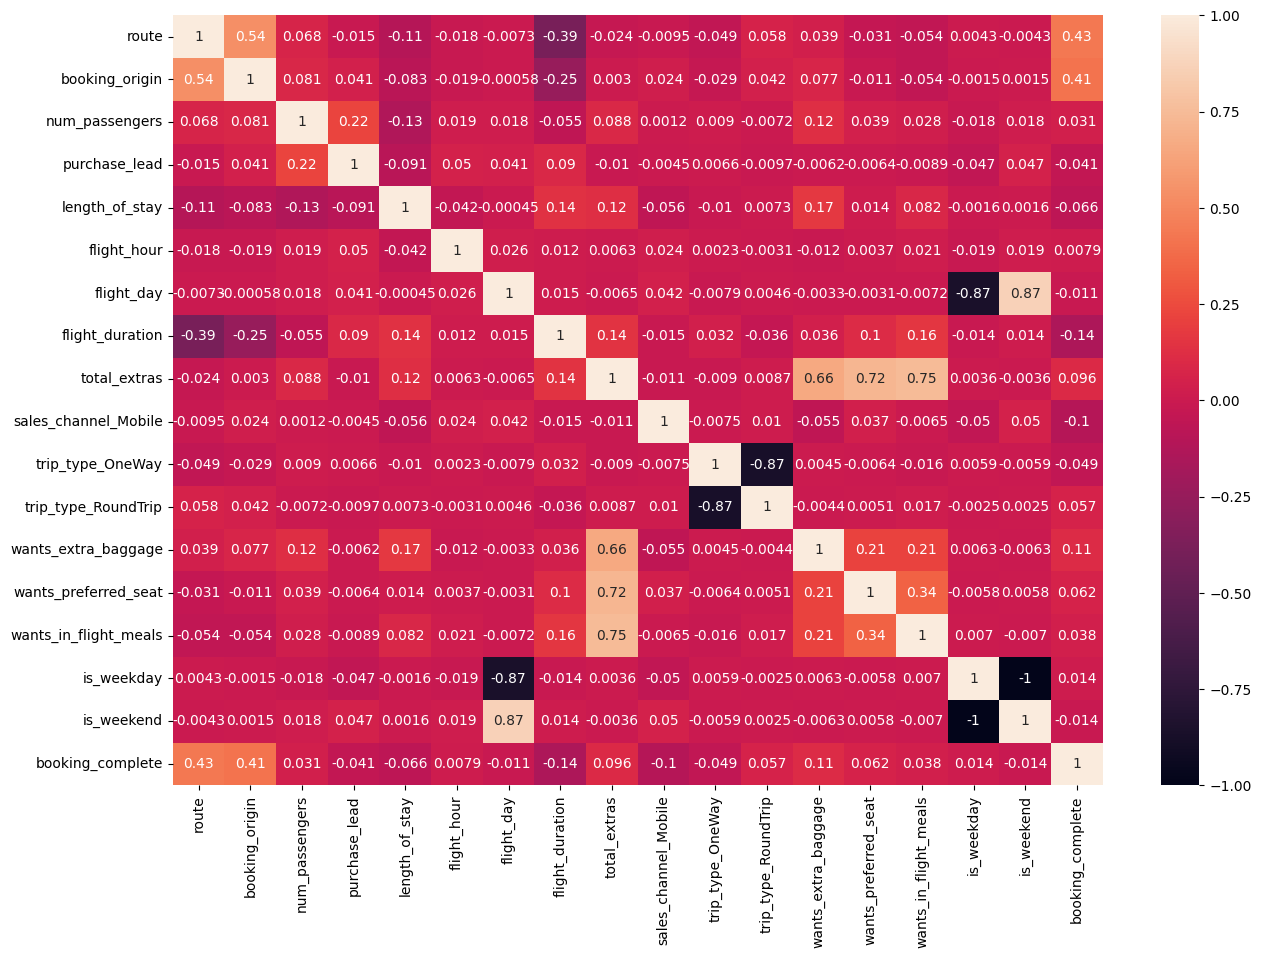

In [424]:
plt.figure(figsize=(15,10))
sns.heatmap(df_train_newcols.corr(),annot=True)


### Insight:
* We can see that flight_day,is_weekend and is_weekday are highly correlated amongst eachother for obvious reasons, we will keep one of them.
* Similarly, total_extras represent the 3 want's columns, so we can keep only total extras

In [425]:
X_train,y_train = df_train_newcols.drop(['booking_complete','flight_day','wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'is_weekday'],axis=1),df_train_newcols['booking_complete']



In [426]:
X_test,y_test = df_test_newcols.drop(['booking_complete','flight_day','wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'is_weekday'],axis=1),df_test_newcols['booking_complete']


In [427]:
model_trained_newcolssmote = train_models(models, X_train, y_train)

In [428]:
report_newcolssmote,confusion_matrices_newcolssmote, roc_curves_newcolssmote, classification_reports_newcolssmote = evaluate_models(model_trained_newcolssmote, X_train, y_train, X_test, y_test)

In [429]:
report_newcolssmote

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8353,0.322973,0.623634,0.425646,0.367269
1,GradientBoostingClassifier,0.843627,0.7899,0.523649,0.679899,0.356978,0.424541
2,ExtraTreesClassifier,0.999926,0.8249,0.341892,0.625347,0.394388,0.366269
3,LogisticRegression,0.733325,0.7322,0.683784,0.712197,0.314091,0.430455
4,XGBClassifier,0.923784,0.8445,0.193243,0.575436,0.442040,0.268923
5,SVM,0.759485,0.7146,0.729054,0.720572,0.305493,0.430567
6,Naive Bayes,0.630581,0.4070,0.871622,0.598956,0.183499,0.303173
7,Decision Tree,0.999926,0.7814,0.364865,0.609310,0.302352,0.330680


## Insights:
* We can see that ROC curves are decent but models are not performing well on classifying 1

# 3. Trying with mutual info_smote selected columns of new cols dataset

In [433]:
X_train_smote_mi = pd.read_csv('dataset_mutualinfo_smote_newcols/X_train_smote_mi_newcols.csv')
y_train_smote_mi= pd.read_csv('dataset_mutualinfo_smote_newcols/y_train_smote_mi_newcols.csv')
X_test_mi= pd.read_csv('dataset_mutualinfo_smote_newcols/X_test_mi_newcols.csv')
y_test_mi= pd.read_csv('dataset_mutualinfo_smote_newcols/y_test_mi_newcols.csv')

In [435]:
X_train_smote_mi.head()

,route,booking_origin,flight_duration,trip_type_RoundTrip,length_of_stay,wants_extra_baggage,is_weekday
0,2.296482,1.794457,-0.436058,1.0,-0.538770,0.0,0.0
1,-0.653994,0.754554,1.039153,1.0,-0.568591,1.0,1.0
2,-0.609062,-0.461472,-0.436058,1.0,-0.508949,1.0,1.0
3,0.468009,-0.921484,0.872274,1.0,-0.061631,1.0,0.0
4,-0.418481,-0.461472,-0.436058,1.0,-0.091452,1.0,0.0


In [389]:
X_train_smote_mi.shape , X_test_mi.shape

((68004, 7), (10000, 7))

In [437]:
model_trained_mi_newcolssmote = train_models(models, X_train_smote_mi, y_train_smote_mi['booking_complete'])

In [438]:
report_mi_newcolssmote,confusion_matrices_mi_newcolssmote, roc_curves_mi_newcolssmote, classification_reports_mi_newcolssmote = evaluate_models(model_trained_mi_newcolssmote, X_train_smote_mi, y_train_smote_mi['booking_complete'],X_test_mi, y_test_mi['booking_complete'])

In [439]:
report_mi_newcolssmote

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.934136,0.7910,0.418243,0.636997,0.334957,0.371995
1,GradientBoostingClassifier,0.791512,0.7547,0.647973,0.710606,0.331719,0.438801
2,ExtraTreesClassifier,0.934151,0.7929,0.404730,0.632529,0.334824,0.366473
3,LogisticRegression,0.723663,0.7301,0.705405,0.719898,0.315694,0.436181
4,XGBClassifier,0.870081,0.8060,0.485811,0.673715,0.378820,0.425696
5,SVM,0.735310,0.6960,0.756757,0.721101,0.294737,0.424242
6,Naive Bayes,0.711885,0.6254,0.822297,0.706747,0.258936,0.393851
7,Decision Tree,0.934151,0.7861,0.401351,0.627143,0.321603,0.357078


## 3.5 Trying with og_smote dataset with MI selected cols

In [698]:
X_train_smote_mi_og = pd.read_csv('OG_MI_SMOTE/X_train_smote_mi_og.csv')
y_train_smote_mi_og = pd.read_csv('OG_MI_SMOTE/y_train_smote_mi_og.csv')
X_test_mi_og = pd.read_csv('OG_MI_SMOTE/X_test_mi_og.csv')
y_test_mi_og = pd.read_csv('OG_MI_SMOTE/y_test_mi_og.csv')

In [699]:
X_train_smote_mi_og.head()

,route,booking_origin,flight_duration,trip_type_RoundTrip,length_of_stay,wants_extra_baggage,wants_in_flight_meals
0,2.296482,1.794457,-0.436058,1.0,-0.538770,0.0,1.0
1,-0.653994,0.754554,1.039153,1.0,-0.568591,1.0,0.0
2,-0.609062,-0.461472,-0.436058,1.0,-0.508949,1.0,0.0
3,0.468009,-0.921484,0.872274,1.0,-0.061631,1.0,0.0
4,-0.418481,-0.461472,-0.436058,1.0,-0.091452,1.0,1.0


In [368]:
X_train_smote_mi_og.shape , X_test_mi_og.shape

((68004, 7), (10000, 7))

In [395]:
model_trained_mi_og = train_models(models, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'])

In [396]:
model_report_miog,confusion_matrices_miog, roc_curves_miog, classification_reports_miog = evaluate_models(model_trained_mi_og,X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'],X_test_mi_og, y_test_mi_og['booking_complete'])

In [397]:
model_report_miog

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.933607,0.7927,0.434459,0.644695,0.342203,0.382852
1,GradientBoostingClassifier,0.793762,0.7560,0.658108,0.715556,0.334938,0.443938
2,ExtraTreesClassifier,0.933636,0.7914,0.412162,0.634720,0.334064,0.369026
3,LogisticRegression,0.725119,0.7317,0.700000,0.718603,0.316336,0.435752
4,XGBClassifier,0.871581,0.8030,0.481757,0.670280,0.372129,0.419906
5,SVM,0.737001,0.6992,0.754054,0.721863,0.296809,0.425954
6,Naive Bayes,0.711782,0.6232,0.819595,0.704340,0.257319,0.391669
7,Decision Tree,0.933636,0.7771,0.407432,0.624373,0.308440,0.351092


# 4.  Trying with all cols_smote

In [398]:
df_train = pd.read_csv('new_cols_smote/df_train_smote_newcols.csv')
df_test = pd.read_csv('new_cols_smote/df_test_smote_newcols.csv')

In [399]:
X_train,y_train = df_train.drop('booking_complete',axis=1),df_train['booking_complete']


In [400]:
X_test,y_test = df_test.drop('booking_complete',axis=1),df_test['booking_complete']


In [401]:
X_train.shape, X_test.shape

((68004, 17), (10000, 17))

In [402]:
model_trained_allcols = train_models(models, X_train,y_train)

C:\Users\Swamesh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [403]:
model_report_allcols,confusion_matrices_allcols, roc_curves_allcols, classification_reports_allcols = evaluate_models(model_trained_allcols,X_train,y_train, X_test,y_test)

In [440]:
model_report_allcols

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score,Report
0,RandomForestClassifier,0.999926,0.8375,0.320946,0.624088,0.433790,0.368932,SMote_allcols
1,GradientBoostingClassifier,0.857361,0.8025,0.477027,0.668032,0.370215,0.416888,SMote_allcols
2,ExtraTreesClassifier,0.999926,0.8296,0.321622,0.619731,0.404762,0.358434,SMote_allcols
3,LogisticRegression,0.733280,0.7335,0.685135,0.713518,0.315593,0.432133,SMote_allcols
4,XGBClassifier,0.925122,0.8471,0.181757,0.572216,0.458262,0.260281,SMote_allcols
5,SVM,0.765793,0.7169,0.717568,0.717176,0.305612,0.428658,SMote_allcols
6,Naive Bayes,0.633595,0.4075,0.868243,0.597854,0.183179,0.302531,SMote_allcols
7,Decision Tree,0.999926,0.7751,0.358108,0.602822,0.289776,0.320338,SMote_allcols


# 5. Trying by removing route and booking origin with smote

In [207]:
tr = df_train.copy()

In [208]:
tr.drop(['route', 'booking_origin'],axis=1,inplace=True)

In [209]:
tr.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'flight_duration', 'total_extras', 'sales_channel_Mobile',
       'trip_type_OneWay', 'trip_type_RoundTrip', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'is_weekday',
       'is_weekend', 'booking_complete'],
      dtype='object')

In [210]:
ts = df_test.copy()

In [211]:
ts.drop(['route', 'booking_origin'],axis=1,inplace=True)

In [212]:
xtr,ytr = tr.drop('booking_complete',axis=1) , tr['booking_complete']
xts,yts = ts.drop('booking_complete',axis=1) , ts['booking_complete']

In [213]:
mod = train_models(models,xtr,ytr)

In [214]:
rep,cm,roc,cr = evaluate_models(mod,xts,yts)

In [216]:
rep

,Model,Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.8245,0.139865,0.541646,0.300435,0.190871
1,GradientBoostingClassifier,0.8310,0.153378,0.551044,0.341867,0.211754
2,ExtraTreesClassifier,0.8135,0.164865,0.545519,0.279496,0.207395
3,LogisticRegression,0.5834,0.630405,0.602820,0.204965,0.309350
4,XGBClassifier,0.8491,0.036486,0.513372,0.394161,0.066790
5,SVM,0.6398,0.581757,0.615820,0.223985,0.323441
6,Naive Bayes,0.2417,0.906757,0.516465,0.152726,0.261420
7,Decision Tree,0.7396,0.267568,0.544582,0.206681,0.233216


## Insights:
* Removing route and booking origin decreases the performance

# 6. Using randomoversampler with new cols

In [352]:
X_train_rs = pd.read_csv('random_sampling_allcols/X_train_rs_allcols.csv')
y_train_rs= pd.read_csv('random_sampling_allcols/y_train_rs_allcols.csv')
X_test= pd.read_csv('random_sampling_allcols/X_test_for_rs_allcols.csv')
y_test= pd.read_csv('random_sampling_allcols/y_test_for_rs_allcols.csv')

In [353]:
X_train_rs.head()

,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,total_extras,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,is_weekday,is_weekend
0,2.296482,1.794457,-0.582751,-0.773097,-0.538770,0.726956,1.595610,-0.436058,-0.388061,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-0.653994,0.754554,-0.582751,2.360878,-0.568591,-0.012426,-1.410626,1.039153,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.609062,-0.461472,0.401834,1.275615,-0.508949,-0.751808,-0.408547,-0.436058,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.468009,-0.921484,-0.582751,-0.064353,-0.061631,0.357265,1.094570,0.872274,-0.388061,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.418481,-0.461472,-0.582751,0.223574,-0.091452,-0.566963,1.595610,-0.436058,0.608756,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


In [354]:
X_train_rs.shape,X_test.shape

((68004, 17), (10000, 17))

In [355]:
mod_rs = train_models(models,X_train_rs,y_train_rs['booking_complete'])

In [356]:
rep_rs,cm_rs,roc_rs,cr_rs = evaluate_models(mod,X_train_rs,y_train_rs['booking_complete'],X_test,y_test['booking_complete'])

In [357]:
rep_rs

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8407,0.291216,0.613683,0.442051,0.351120
1,GradientBoostingClassifier,0.743927,0.7039,0.757432,0.726017,0.301101,0.430905
2,ExtraTreesClassifier,0.999926,0.8483,0.192568,0.577387,0.469522,0.273119
3,LogisticRegression,0.728472,0.7310,0.692568,0.715122,0.314417,0.432489
4,XGBClassifier,0.846141,0.7351,0.670946,0.708595,0.314739,0.428479
5,SVM,0.747721,0.7054,0.750000,0.723826,0.301139,0.429733
6,Naive Bayes,0.691106,0.5535,0.861486,0.680743,0.230352,0.363507
7,Decision Tree,0.999926,0.7961,0.314865,0.597280,0.312542,0.313699


# 7. __Random sample without redundant cols__

In [241]:
X_train_rs.columns

Index(['route', 'booking_origin', 'num_passengers', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'flight_duration',
       'total_extras', 'sales_channel_Mobile', 'trip_type_OneWay',
       'trip_type_RoundTrip', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'is_weekday', 'is_weekend'],
      dtype='object')

__X_train_rs_nored : x train of resampled with no redundant cols__

In [324]:
X_train_rs_nored,y_train_rs_nored = X_train_rs.drop(['flight_day','wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'is_weekday'],axis=1),y_train_rs


In [327]:
X_test_nored,y_test_nored = X_test.drop(['flight_day','wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'is_weekday'],axis=1),y_test

In [329]:
mod_rs_noredundantcols = train_models(models,X_train_rs_nored,y_train_rs_nored['booking_complete'])

In [330]:
rep_rs_noredundantcols,cm_rs_noredundantcols,roc_rs_noredundantcols,cr_rs_noredundantcols = evaluate_models(mod_rs_noredundantcols,X_train_rs_nored,y_train_rs_nored['booking_complete'],X_test_nored,y_test_nored['booking_complete'])

In [331]:
rep_rs_noredundantcols

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8444,0.295946,0.617809,0.460084,0.360197
1,GradientBoostingClassifier,0.744544,0.7025,0.758108,0.725474,0.300080,0.429967
2,ExtraTreesClassifier,0.999926,0.8470,0.188514,0.574949,0.458882,0.267241
3,LogisticRegression,0.728545,0.7311,0.690541,0.714343,0.314172,0.431861
4,XGBClassifier,0.837671,0.7311,0.688514,0.713506,0.313828,0.431140
5,SVM,0.742339,0.7032,0.758108,0.725885,0.300643,0.430545
6,Naive Bayes,0.692283,0.5564,0.852027,0.678537,0.230194,0.362460
7,Decision Tree,0.999926,0.7971,0.314189,0.597588,0.314402,0.314295


# 8. Using on Random sample over og columns

In [720]:
X_train_rs_og = pd.read_csv('RS_OG/X_train_rs_og.csv')
y_train_rs_og= pd.read_csv('RS_OG/y_train_rs_og.csv')
X_test= pd.read_csv('RS_OG/X_test_for_rs_og.csv')
y_test= pd.read_csv('RS_OG/y_test_for_rs_og.csv')

In [724]:
X_train_rs_og.head(2)

,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,2.296482,1.794457,-0.582751,-0.773097,-0.538770,0.726956,1.595610,-0.436058,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.653994,0.754554,-0.582751,2.360878,-0.568591,-0.012426,-1.410626,1.039153,0.0,0.0,1.0,1.0,0.0,0.0


In [726]:
y_train_rs_og.value_counts()

booking_complete
0                   34002
1                   34002
dtype: int64

In [721]:
X_train_rs_og.shape,X_test.shape

((68004, 14), (10000, 14))

In [334]:
mod_rs_og = train_models(models,X_train_rs_og,y_train_rs_og['booking_complete'])

In [335]:
rep_rs_og,cm_rs_og,roc_rs_og,cr_rs_og = evaluate_models(mod_rs_og,X_train_rs_og,y_train_rs_og['booking_complete'],X_test,y_test['booking_complete'])

In [336]:
rep_rs_og

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8456,0.293243,0.617396,0.465665,0.359867
1,GradientBoostingClassifier,0.744059,0.7025,0.760135,0.726312,0.300401,0.430622
2,ExtraTreesClassifier,0.999926,0.8508,0.178378,0.572992,0.488889,0.261386
3,LogisticRegression,0.728310,0.7312,0.693919,0.715797,0.314838,0.433151
4,XGBClassifier,0.845553,0.7392,0.690541,0.719097,0.322194,0.439381
5,SVM,0.747427,0.7048,0.756757,0.726266,0.301724,0.431433
6,Naive Bayes,0.692636,0.5582,0.858108,0.682106,0.231836,0.365047
7,Decision Tree,0.999926,0.7993,0.310811,0.597483,0.317899,0.314315


In [727]:
mod_rs_og_ada = train_models(models,X_train_rs_og,y_train_rs_og['booking_complete'])

rep_rs_og_ada,cm_rs_og_ada,roc_rs_og_ada,cr_rs_og_ada = evaluate_models(mod_rs_og_ada,X_train_rs_og,y_train_rs_og['booking_complete'],X_test,y_test['booking_complete'])

rep_rs_og_ada

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.999926,0.8464,0.291892,0.617307,0.469565,0.360000
1,GradientBoostingClassifier,0.744059,0.7025,0.760135,0.726312,0.300401,0.430622
2,ExtraTreesClassifier,0.999926,0.8489,0.172973,0.569644,0.471455,0.253089
3,LogisticRegression,0.728310,0.7312,0.693919,0.715797,0.314838,0.433151
4,XGBClassifier,0.845553,0.7392,0.690541,0.719097,0.322194,0.439381
5,SVM,0.747427,0.7048,0.756757,0.726266,0.301724,0.431433
6,Naive Bayes,0.692636,0.5582,0.858108,0.682106,0.231836,0.365047
7,Adaboostclassif,0.733957,0.7031,0.744595,0.720243,0.298402,0.426058


# 9. Using on Random sample over og columns with Mutual Info

In [705]:
X_tr_rs_ogmi = pd.read_csv('OG_MI_RS/X_tr_rs_ogmi.csv')
y_tr_rs_ogmi = pd.read_csv('OG_MI_RS/y_tr_rs_ogmi.csv')
X_ts_rs_ogmi= pd.read_csv('OG_MI_RS/X_ts_for_rsogmi.csv')
y_ts_rs_ogmi = pd.read_csv('OG_MI_RS/y_ts_for_rsogmi.csv')

In [706]:
X_tr_rs_ogmi.shape,X_ts_rs_ogmi.shape

((68004, 7), (10000, 7))

In [707]:
y_tr_rs_ogmi.value_counts()

booking_complete
0                   34002
1                   34002
dtype: int64

In [364]:
mod_rs_og_mi = train_models(models,X_tr_rs_ogmi,y_tr_rs_ogmi['booking_complete'])

In [365]:
rep_rs_og_mi,cm_rs_og_mi,roc_rs_og_mi,cr_rs_og_mi = evaluate_models(mod_rs_og_mi,X_tr_rs_ogmi,y_tr_rs_ogmi['booking_complete'],X_ts_rs_ogmi,y_ts_rs_ogmi['booking_complete'])

In [366]:
rep_rs_og_mi

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.903432,0.7511,0.515541,0.653780,0.300986,0.380075
1,GradientBoostingClassifier,0.739148,0.7005,0.772973,0.730442,0.300815,0.433087
2,ExtraTreesClassifier,0.903447,0.7557,0.489865,0.645871,0.300456,0.372463
3,LogisticRegression,0.723163,0.7314,0.700676,0.718706,0.316159,0.435714
4,XGBClassifier,0.794115,0.7168,0.722297,0.719071,0.306304,0.430181
5,SVM,0.732957,0.6960,0.768919,0.726126,0.296663,0.428141
6,Naive Bayes,0.721958,0.6630,0.792568,0.716530,0.276912,0.410427
7,Decision Tree,0.903447,0.7379,0.510135,0.643800,0.284798,0.365529


## Insights:
* Random Forest, Gradient boosting and XGB are overfitting since they have high train accuracy and low test accuracy

## 9. Graphically comparing model performance for metrics across reports

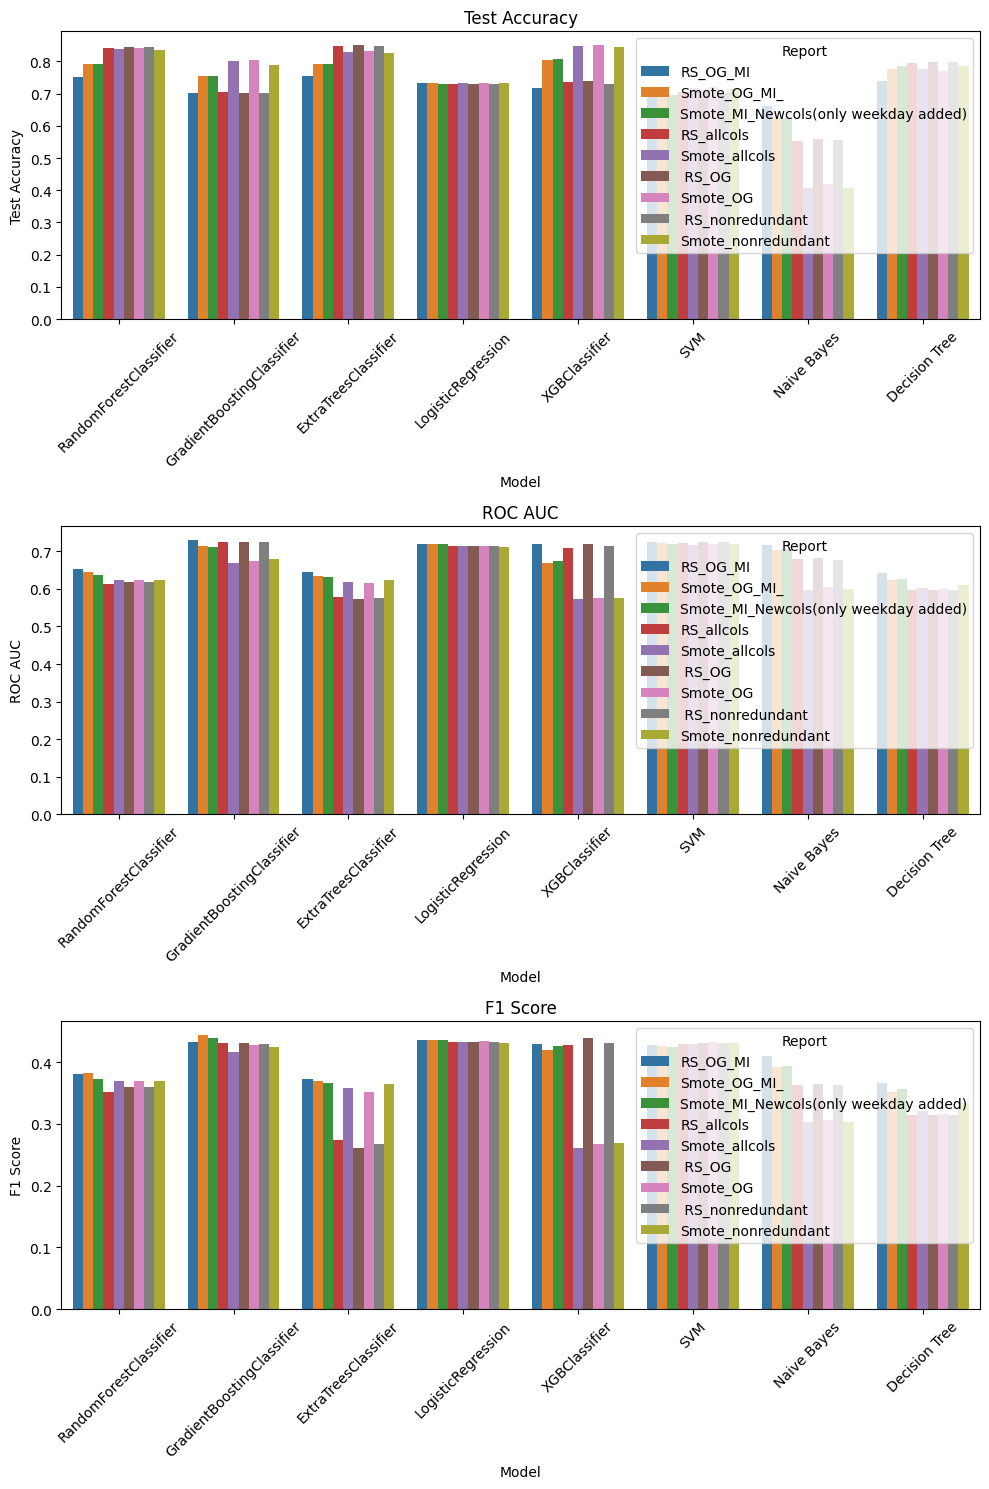

In [441]:
dataframes = [rep_rs_og_mi, model_report_miog , report_mi_newcolssmote, rep_rs, model_report_allcols
              , rep_rs_og, report_ogsmote , rep_rs_noredundantcols , report_mi_newcolssmote]


titles = ['RS_OG_MI','Smote_OG_MI_',"Smote_MI_Newcols(only weekday added)", "RS_allcols" ,'Smote_allcols'  ,
          " RS_OG","Smote_OG"," RS_nonredundant","Smote_nonredundant"]

# Combine all dataframes into one with an additional column 'Report'
for i, df in enumerate(dataframes):
    df['Report'] = titles[i]
df_all = pd.concat(dataframes)

# Setting the figure size
plt.figure(figsize=(10, 15))

# Creating sub-plots for each metric
metrics = ['Test Accuracy', 'ROC AUC', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    sns.barplot(x='Model', y=metric, hue='Report', data=df_all)
    plt.title(metric)
    plt.xticks(rotation=45)

# Displaying the plots
plt.tight_layout()
plt.show()

## Insights:

* __We can ignore Smote MI newcols__
* __From all RS reports we can keep RS_OG , and from all Smote reports, we can keep SMOTE OG__

* __Accuracy__ 
    * Smote  columns perform better than RS columns for  RF,Gradientboost and xgb
    * Amongst MIs, Smote Mi is doing better than RS
    * Logistic and svm have all reports consistent
* __ROC__ 
    * RS cols performs better than smote for RF,Gradient boost and XGB
    * Logistic , SVM good and consistent.
    * Amongst MIs, RS MI is doing slightly better than Smote MIs. In general RS MI is betetr than all reports.

* __F1__ :
    * All MIs doing better than other reports.
    * RS are better for GB and XGB.
    * Logistic, SVM consistent
    

    
* __Models__ :
    * Gradient boosting smote og MI can be considered consiering all 3 metrics.
    * Logistic,SVM  regression consistent across reports for all metrics
    * XGB smote og MI considering all metrics.

    * RF smote og can be taken.
    

## Inshort, we can move ahead with Smote_OG_MI
## Out of all reports, we can keep RS_OG_MI, Smote_OG_MI , RS_OG and SMote_OG.

## Lets visualize again
    
                 - 

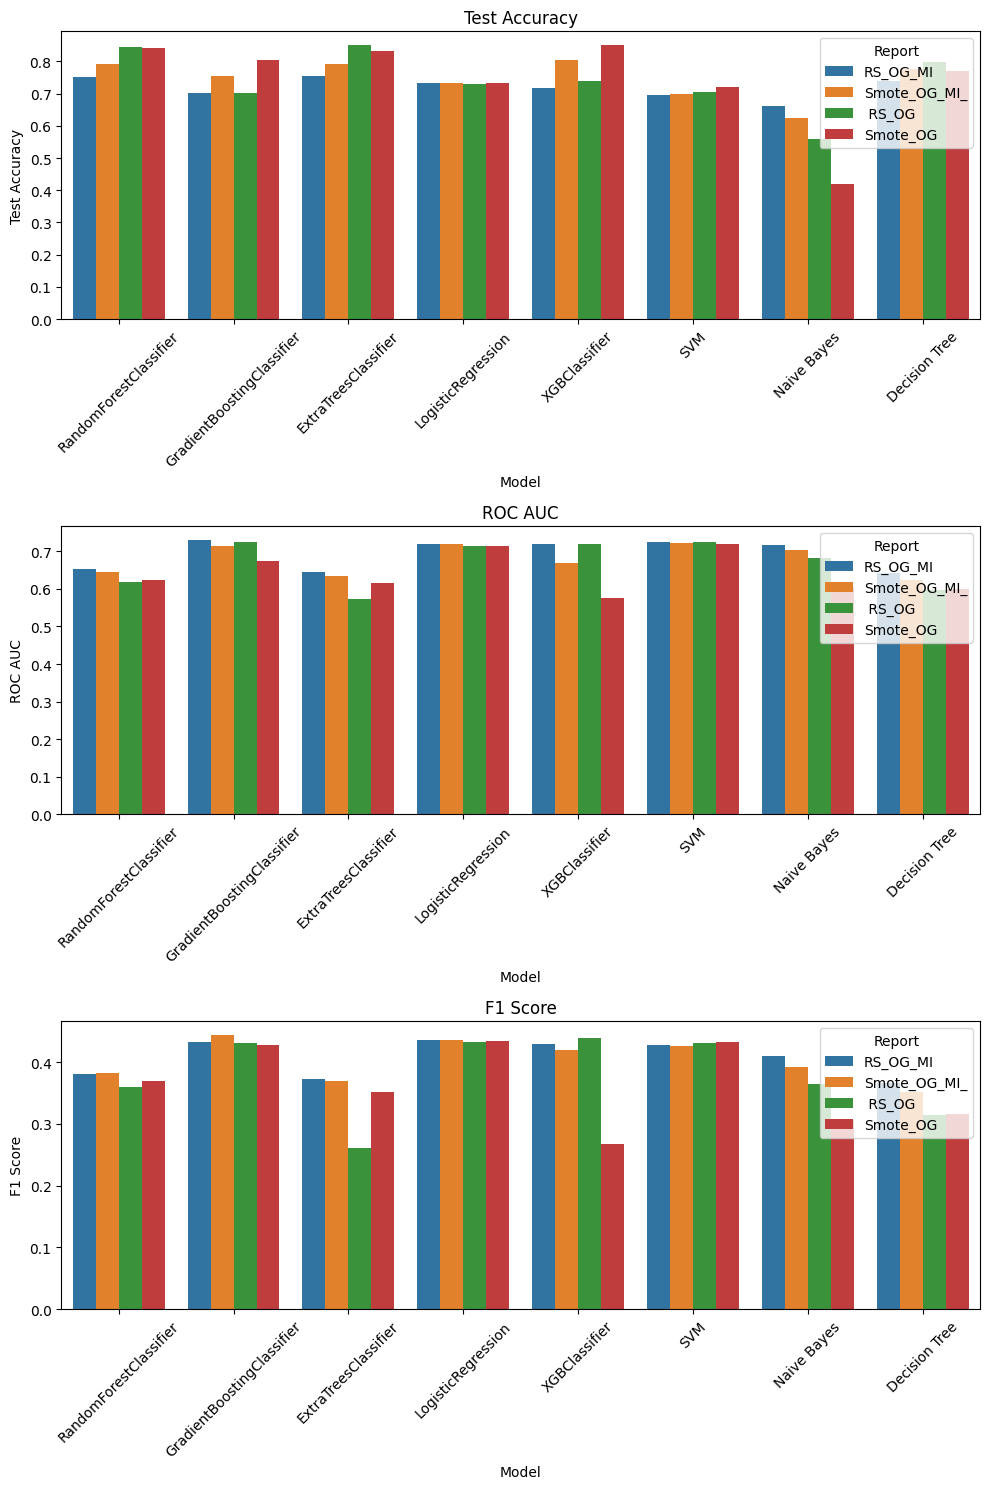

In [445]:
dataframes = [rep_rs_og_mi, model_report_miog , rep_rs_og, report_ogsmote ]


titles = ['RS_OG_MI','Smote_OG_MI_'," RS_OG","Smote_OG" ]

# Combine all dataframes into one with an additional column 'Report'
for i, df in enumerate(dataframes):
    df['Report'] = titles[i]
df_all = pd.concat(dataframes)

# Setting the figure size
plt.figure(figsize=(10, 15))

# Creating sub-plots for each metric
metrics = ['Test Accuracy', 'ROC AUC', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i+1)
    sns.barplot(x='Model', y=metric, hue='Report', data=df_all)
    plt.title(metric)
    plt.xticks(rotation=45)

# Displaying the plots
plt.tight_layout()
plt.show()

## Dataset to be used model_report_miog that is SMOTE_OG_MI

__-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

In [ ]:
df = 